# **Overview**



**Data augmentation**: một kỹ thuật để tăng tính đa dạng của tập huấn luyện bằng cách áp dụng các phép biến đổi ngẫu nhiên (nhưng thực tế) như xoay hình ảnh.Có thể áp dụng tăng dữ liệu theo hai cách. Đầu tiên,sẽ sử dụng `Keras Preprocessing Layers`. Tiếp theo, sẽ sử dụng `tf.image.`

# **Setup**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


# **Download datasets**

Sử dụng tập dữ liệu [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) 

In [ ]:
(train_data , valid_data, test_data), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Tập dữ liệu có 5 lớp

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Xem một ảnh ngẫu nhiên

Text(0.5, 1.0, 'tulips')

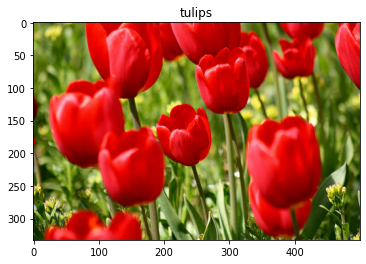

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_data))
plt.imshow(image)
plt.title(get_label_name(label))

# **Tiền sử lý với Keras**

## **Resizing and rescaling**

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential(
    [
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
    ]
)

**Chú ý**: `rescaling` tiêu chuẩn hóa các giá trị pixel về `[0,1]`. Nếu muốn về `[-1,1]` thì sẽ viết `Rescaling(1/127.5, offset = -1)`

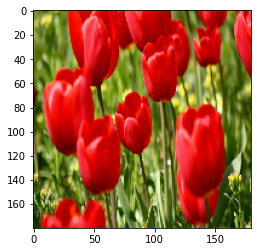

In [ ]:
result = resize_and_rescale(image)
plt.imshow(result)

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


## **Data augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
     layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

In [ ]:
# add the image to a batch
image = tf.expand_dims(image, 0)

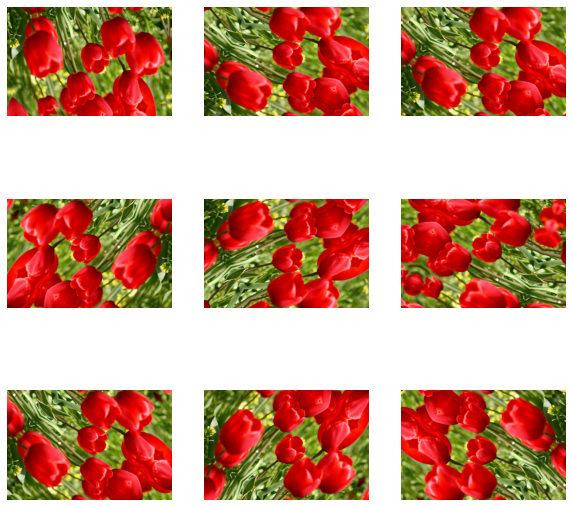

In [ ]:
plt.figure( figsize = (10, 10))
for i in range(9):
  augmentation_image = data_augmentation(image)
  plt.subplot(3, 3, i + 1)
  plt.imshow(augmentation_image[0])
  plt.axis('off')

## **Hai tùy chọn để sử dụng các lớp tiền xử lý**

Có hai cách thường có thể sử dụng các lớp tiền xử lý, với những đánh đổi quan trọng.

### Tùy chọn 1: Đặt các lớp tiền xử lý trở thành một phần của mô hình.

In [ ]:
model = tf.keras.Sequential(
    [
     resize_and_rescale,
     data_augmentation,
     layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
     layers.MaxPool2D(),
    ]
)

Có hai điểm quan trọng cần lưu ý trong trường hợp này:
>- Tăng cường dữ liệu sẽ chạy trên thiết bị, đồng bộ với các lớp còn lại và được hưởng lợi từ việc tăng tốc GPU.
>- Khi xuất mô hình bằng cách sử dụng `model.save`, các lớp tiền xử lý sẽ được lưu cùng với phần còn lại của mô hình . Nếu sau này triển khai mô hình này, nó sẽ tự động chuẩn hóa hình ảnh (theo cấu hình của các lớp của bạn). Điều này có thể giúp tiết kiệm khỏi nỗ lực phải thực hiện lại phía máy chủ logic đó.

**chú ý**: Tính năng tăng dữ liệu không hoạt động tại thời điểm thử nghiệm nên hình ảnh đầu vào sẽ chỉ được tăng cường trong các cuộc gọi tới`model.fit`(không phải `model.predict` hay `model.evaluate`

### Tùy chọn 2: Áp dụng các lớp tiền xử lý cho tập dữ liệu

In [ ]:
aug_ds = train_data.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))
aug_ds

<MapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>

Với cách tiếp cận này, chúng ta sử dụng Dataset.map để tạo tập dữ liệu mang lại các lô hình ảnh tăng cường. Trong trường hợp này:
>- Việc tăng dữ liệu sẽ diễn ra không đồng bộ trên CPU và không bị chặn. Có thể chồng chéo việc đào tạo mô hình của mình trên GPU với việc xử lý trước dữ liệu, bằng cách sử dụng `Dataset.prefetch`
>- Trong trường hợp này, các lớp tiền xử lý sẽ không được xuất cùng với mô hình khi gọi `model.save`.Ta sẽ cần đính kèm chúng vào mô hình của mình trước khi lưu hoặc thực hiện lại chúng ở phía máy chủ.Sau khi đào tạo, có thể đính kèm các lớp tiền xử lý trước khi xuất.

## **Áp dụng các lớp tiền xử lý cho tập dữ liệu**

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle = False, augment = False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls  = AUTOTUNE)
  
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training = True),y),
                num_parallel_calls = AUTOTUNE)
  
  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size = AUTOTUNE)

In [ ]:
train_data = prepare(train_data, shuffle = True, augment = True)
valid_data = prepare(valid_data)
test_data = prepare(test_data)

In [ ]:
train_data

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int64)>

## **Train a model**

In [ ]:
model = tf.keras.Sequential(
    [
     Conv2D(16, 3, padding = 'same', activation = 'relu'),
     MaxPooling2D(),
     Conv2D(32, 3, padding = 'same', activation = 'relu'),
     MaxPooling2D(),
     Conv2D(64, 3, padding = 'same', activation = 'relu'),
     MaxPooling2D(),
     Flatten(),
     Dense(128, activation = 'relu'),
     Dense(num_classes)
    ]
)

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'Adam',
              metrics = ['accuracy'])

history = model.fit(train_data, epochs = 5,
                    validation_data = valid_data)

Epoch 1/5
92/92 [==============================] - 45s 153ms/step - loss: 1.4562 - accuracy: 0.3750 - val_loss: 1.2123 - val_accuracy: 0.5041
Epoch 2/5
92/92 [==============================] - 12s 121ms/step - loss: 1.1098 - accuracy: 0.5521 - val_loss: 1.0437 - val_accuracy: 0.5995
Epoch 3/5
92/92 [==============================] - 12s 120ms/step - loss: 1.0186 - accuracy: 0.5947 - val_loss: 0.9745 - val_accuracy: 0.6322
Epoch 4/5
92/92 [==============================] - 12s 121ms/step - loss: 0.9587 - accuracy: 0.6298 - val_loss: 0.9765 - val_accuracy: 0.6267
Epoch 5/5
92/92 [==============================] - 12s 125ms/step - loss: 0.9088 - accuracy: 0.6482 - val_loss: 0.9848 - val_accuracy: 0.6158


In [ ]:
loss, acc = model.evaluate(test_data)
print("Accuracy", acc)

12/12 [==============================] - 1s 54ms/step - loss: 0.8917 - accuracy: 0.6485
Accuracy 0.6485013365745544


In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

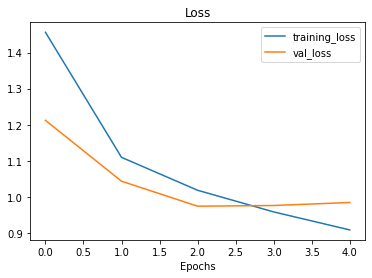

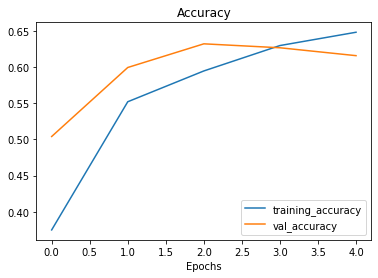

In [ ]:
plot_loss_curves(history)

## **Tăng dữ liệu tùy chỉnh**

Ngoài việc sử dụng các cách tăng dữ liệu có sẵn thì chúng ta cũng có thể tùy chỉnh theo ý muốn. Có hai cách để tăng dữ liệu tùy chỉnh:
>- Tạo lớp `layers.lambda`. Đây là một cách tốt để viết mã ngắn gọn.
>- Viết một lớp mới thông qua `subclasing`, cung cấp nhiều quyền kiểm soát hơn

Cả hai lớp sẽ đảo ngược màu một cách ngẫu nhiên trong một hình ảnh, theo một số xác suất.

In [ ]:
def random_invert_img(x, p = 0.5):
  if tf.random.uniform([]) < p:
    x = (255 - x)
  else:
    x
  return x

In [ ]:
def random_invert(factor = 0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()
random_invert

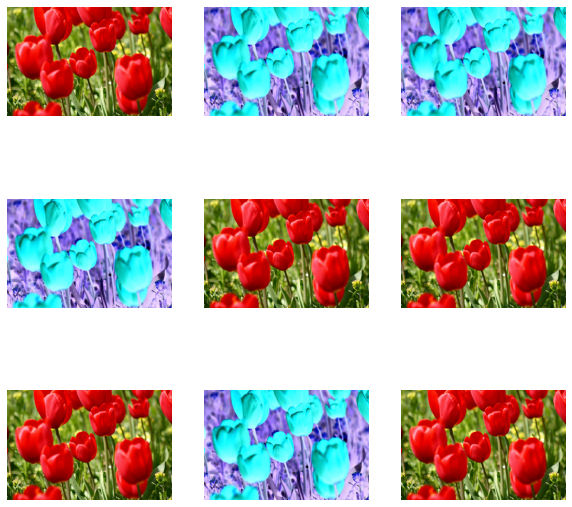

In [ ]:
plt.figure(figsize = (10,10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype('uint8'))
  plt.axis('off')

Tiếp theo, triển khai một lớp tùy chỉnh bằng `subclasing`

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor = 0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  
  def call(self, x):
    return random_invert_img(x)

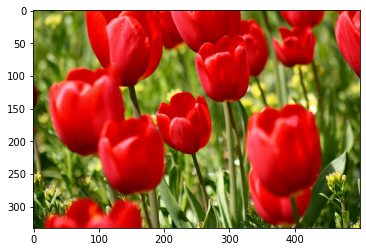

In [ ]:
plt.imshow(RandomInvert()(image)[0])

Cả hai lớp này có thể được sử dụng như được mô tả trong tùy chọn 1 và 2 ở trên.

# **Sử dụng `tf.image`**

Các tiện ích xử lý `layer.preprocessing` ở trên rất tiện lợi. Để kiểm soát tốt hơn, chúng ta có thể viết các đường ống hoặc lớp tăng dữ liệu của riêng mình bằng cách sử dụng `tf.data` và `tf.image`

Vì tập dữ liệu về hoa trước đây đã được định cấu hình bằng cách tăng dữ liệu, hãy nhập lại để bắt đầu làm mới.

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Text(0.5, 1.0, 'tulips')

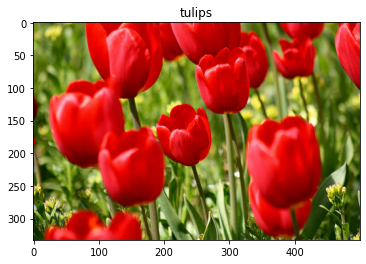

In [ ]:
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label))

Sử dụng chức năng sau để trực quan hóa và so sánh các hình ảnh gốc và hình ảnh tăng cường cạnh nhau.

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

## Data augmentation

### Flipping the image - lật ảnh

Lật hình ảnh theo chiều dọc hoặc chiều ngang.

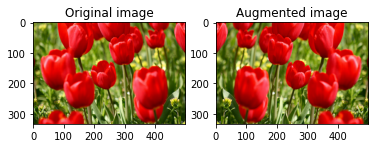

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale the image

Chuyển hệ màu của hình ảnh về hệ màu xám

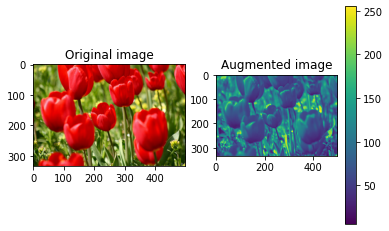

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

### Saturate the image

Làm bão hòa hình ảnh bằng cách cung cấp hệ số bão hòa.

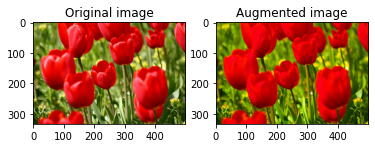

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### Change image brightness

Thay đổi độ sáng của hình ảnh bằng cách cung cấp hệ số độ sáng.

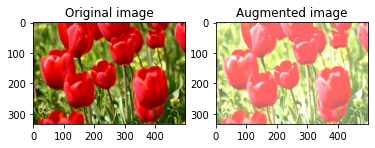

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### Center crop the image

Cắt hình ảnh từ giữa lên đến phần hình ảnh bạn muốn.

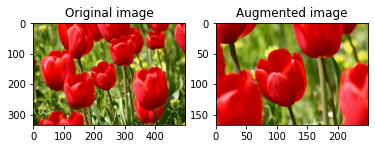

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### Rotate the image

Xoay hình ảnh 90 độ

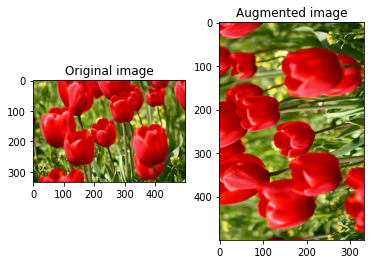

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

## Random transformations

Việc áp dụng các phép biến đổi ngẫu nhiên cho hình ảnh có thể giúp tổng quát hóa và mở rộng tập dữ liệu hơn nữa

`API tf.image` hiện tại cung cấp 8 hoạt động hình ảnh ngẫu nhiên như vậy (hoạt động):
- `tf.image.stateless_random_brightness`
- `tf.image.stateless_random_contrast`
- `tf.image.stateless_random_crop`
- ` tf.image.stateless_random_flip_left_right`
- ` tf.image.stateless_random_flip_up_down`
- ` tf.image.stateless_random_hue`
- `tf.image.stateless_random_jpeg_quality`
- `tf.image.stateless_random_saturation`

Các hoạt động hình ảnh ngẫu nhiên này hoàn toàn có chức năng: đầu ra chỉ phụ thuộc vào đầu vào.Điều này làm cho chúng dễ sử dụng với hiệu suất cao,đường ống đầu vào xác định. Chúng yêu cầu 1  giá trị hạt giống (`seed`) được nhập vào mỗi bước. Cho cùng một hạt giống, chúng trả về cùng một kết quả độc lập với số lần chúng được gọi.



### Randomly change image brightness

Thay đổi ngẫu nhiên độ sáng của hình ảnh bằng cách cung cấp hệ số độ sáng và `seed`.Hệ số độ sáng được chọn ngẫu nhiên trong phạm vi `[-max_delta, max_delta)` và được liên kết với `seed` đã cho.

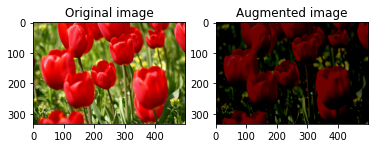

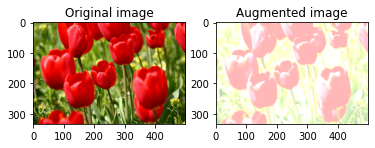

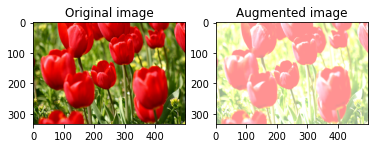

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

### Randomly change image contrast

Thay đổi ngẫu nhiên độ tương phản của hình ảnh bằng cách cung cấp dải tương phản và `seed`. Phạm vi tương phản được chọn ngẫu nhiên trong khoảng `[lower, upper]` và được liên kết với `seed` đã cho.

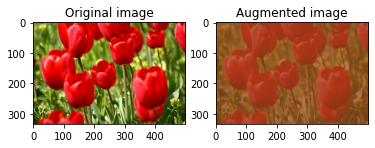

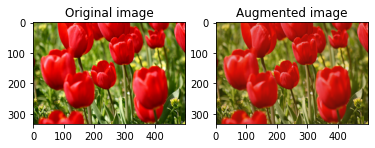

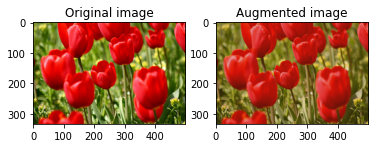

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

### Randomly crop an image

Cắt ngẫu nhiên hình ảnh bằng cách cung cấp `size` mục tiêu và `seed`. Phần bị cắt ra khỏi hình ảnh là phần được chọn ngẫu nhiên và được liên kết với `seed` đã cho

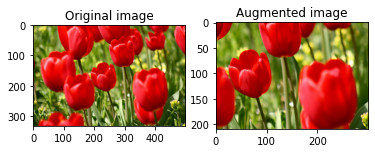

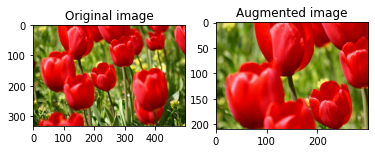

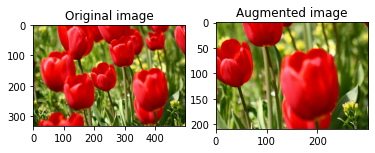

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)